## Customer Segmentation Using RFM Model and K-Means Clustering 

### 1. Import Libraries and Data
a. Import Libraries

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

b. Load Data

In [3]:
# Load Dataset
df = pd.read_csv("Online_Retail.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


### 2. Data Preprocessing and Feature Engineering
a. Overview Data Features and Explore Data

In [4]:
# Information on features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


由前列Dataframe的統計變量表可見Quantity的max和min為絕對值相同的正負數，檢視二筆資料後推論此係一組經取消的訂單，應於分析中排除：

In [6]:
df.loc[df.Quantity.abs() == 80995] #loc返回該列資料

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/11 9:15,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/11 9:27,2.08,16446.0,United Kingdom


由前列Dataframe的統計變量表可見UnitPrice存在負數值，檢視資料後確認其為會計調帳，應於分析中排除：

In [7]:
df.loc[df.UnitPrice<0] #loc返回該列資料

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/11 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/11 14:52,-11062.06,NaN,United Kingdom


b. Remove Noisy Data and Drop Missing Values

實務上，公司經常會基於會計或存貨管理的目的，而有UnitPrice<=0、Quantity<=0的調整帳目存在於系統，為使本分析數據更切合客戶關係管理(CRM)目的，應將這些情形於資料中排除。

經評估，若存在除了前述”Quantity”最大最小值以外的其他取消訂單情況，負數量的訂單已透過移除負數值交易時排除、正數量的訂單若對於數據準確性具有重大影響則會在處理極端值時經移除，故不另針對可能取消訂單一一進行核對處理。

In [8]:
#Remove negative and 0 values in ‘Quantity’ and ‘UnitPrice’ columns 刪除Quantity<=0及UnitPrice<=0的資料
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove canceled order (df["Quantity"] == 80995)
df = df.drop(index = 540421)

In [9]:
# Drop Missing Values(in "Description" & "CustomerID")
df = df.dropna()
print('The total number of data-points after removing the rows with noisy data or missing values are:', len(df))

The total number of data-points after removing the rows with noisy data or missing values are: 397883


c. Check and Change Data Types

In [10]:
#Check and Change Data Types
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

由於客群可能因不同國家產生較大差異，故擬將此分析的資料範圍濃縮為占總資料比重最大之英國客戶進行分析：

In [11]:
df['Country'].value_counts(normalize=True).head(10) #normalize=True會以百分比呈現

United Kingdom    0.890513
Germany           0.022720
France            0.020963
EIRE              0.018186
Spain             0.006243
Netherlands       0.005929
Belgium           0.005105
Switzerland       0.004627
Portugal          0.003674
Australia         0.002971
Name: Country, dtype: float64

In [12]:
df = df[df['Country'] == 'United Kingdom'] #僅保留英國地區之訂單資料
print('The total number of data-points after only keep UK:', len(df))

The total number of data-points after only keep UK: 354320


d. Feature Engineering

In [13]:
# Create a column of total price 新增RFM分析所需之衍生計算欄位
df['Amount'] = df['Quantity'] * df['UnitPrice']
df['YearMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


### 3. RFM Analysis
a. Calculating RFM Values Based on Raw Data

The RFM model is used to understand and segment customers by consumer behavior. RFM represents three metrics (Recency, Frequency, and Monetary):

- Recency (R) — How long it’s been since the customer’s last purchase. A shorter recency indicates the higher customer activity.
- Frequency (F) — How often a customer purchase. A higher frequency indicates greater brand loyalty.
- Monetary (M) — The total amount spent by a customer.

**We will use the last invoice date plus one day as today to calculate Recency.**

In [17]:
# Find the day after last purchase date
today = df['InvoiceDate'].max() + dt.timedelta(days = 1)
today

Timestamp('2011-12-10 12:49:00')

In [18]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate':lambda x: (today - x.max()).days,
                                    'InvoiceNo':'count',
                                    'Amount':'sum'})
rfm.rename(columns = {'InvoiceDate':'Recency',
                     'InvoiceNo':'Frequency',
                     'Amount':'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12747,2,103,4196.01
12748,1,4595,33719.73
12749,4,199,4090.88
12820,3,59,942.34


b. Detect and Remove Extreme Outliers Using IQR Method

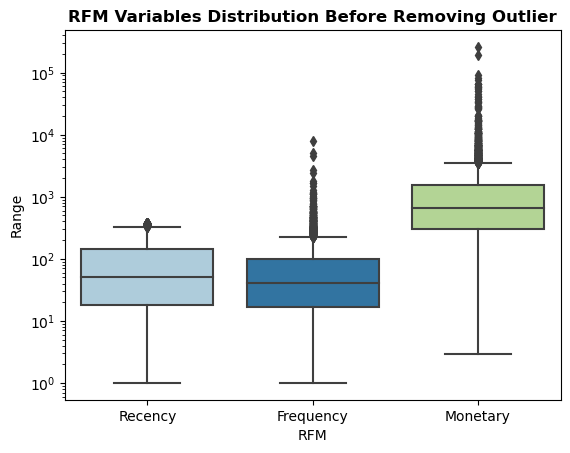

In [19]:
x = ['Recency', 'Frequency', 'Monetary']
sns.boxplot(data = rfm[x], palette = 'Paired')
plt.yscale('log')
plt.title('RFM Variables Distribution Before Removing Outlier', fontweight = 'bold')
plt.ylabel('Range')
plt.xlabel('RFM')
plt.show()

In [20]:
# Detect and Remove Extreme Outliers極端離群值
def remove_outlier(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    dataframe = dataframe[(dataframe[column] >= Q1 - 3 * IQR) & (dataframe[column] <= Q3 + 3 * IQR)]
    return dataframe

In [21]:
rfm = remove_outlier(rfm, 'Recency')
rfm = remove_outlier(rfm, 'Frequency')
rfm = remove_outlier(rfm, 'Monetary')
print('The total number of customer after data cleaning:', len(rfm))

The total number of customer after data cleaning: 3602


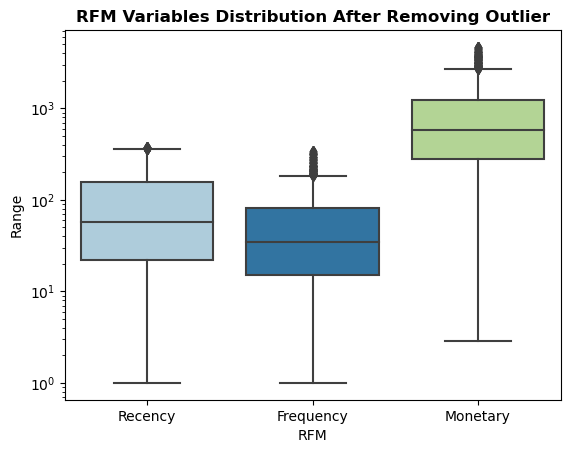

In [22]:
x = ['Recency', 'Frequency', 'Monetary']
sns.boxplot(data = rfm[x], palette = 'Paired')
plt.yscale('log')
plt.title('RFM Variables Distribution After Removing Outlier', fontweight = 'bold')
plt.ylabel('Range')
plt.xlabel('RFM')
plt.show()

c. Assigning Quantile to Each Customer & Calculate RFM Score

In [25]:
rfm['R'] = pd.qcut(rfm['Recency'], q = 4, labels = [4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'], q = 4, labels = [1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], q = 4, labels = [1, 2, 3, 4])
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12747,2,103,4196.01,4,4,4
12749,4,199,4090.88,4,4,4
12820,3,59,942.34,4,3,3
12821,214,6,92.72,1,1,1
12822,71,46,948.88,2,3,3


In [26]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3602 entries, 12747 to 18287
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    3602 non-null   int64   
 1   Frequency  3602 non-null   int64   
 2   Monetary   3602 non-null   float64 
 3   R          3602 non-null   category
 4   F          3602 non-null   category
 5   M          3602 non-null   category
dtypes: category(3), float64(1), int64(2)
memory usage: 123.7+ KB


In [27]:
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1) #axis=0對index、axis=1對column
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12747,2,103,4196.01,4,4,4,12
12749,4,199,4090.88,4,4,4,12
12820,3,59,942.34,4,3,3,10
12821,214,6,92.72,1,1,1,3
12822,71,46,948.88,2,3,3,8


In [28]:
rfm.reset_index(inplace = True) #把原本的舊索引變成一欄，添加新的index；如果用drop=True，當初使用聚合的預設index是customer_id會不見
rfm.tail()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
3597,18278,74,9,173.90,2,1,1,4
3598,18280,278,10,180.60,1,1,1,3
3599,18281,181,7,80.82,1,1,1,3
3600,18282,8,12,178.05,4,1,1,6
3601,18287,43,70,1837.28,3,3,4,10


In [29]:
rfm.describe()

,Recency,Frequency,Monetary,RFM_Score
count,3602.000000,3602.000000,3602.000000,3602.000000
mean,98.553026,59.264020,918.716070,7.501388
std,100.676700,63.263276,926.513658,2.739069
min,1.000000,1.000000,2.900000,3.000000
25%,22.000000,15.000000,277.055000,5.000000
50%,57.000000,35.000000,576.580000,8.000000
75%,157.000000,82.000000,1245.632500,10.000000
max,374.000000,342.000000,4690.310000,12.000000


### 4. K-Means Clustering
K-means演算法是一種常用的聚類(cluster)演算法，用於將 n 個數據點劃分為 k 個聚類。算法的目標是最小化所有點與其所屬聚類中心之間的平方距離之和，使相同聚類的資料具有較高的相似度。

a. Data Preprocessing: Data Scaling & Standardization

K-means分群前之資料預處理：**降低數據分佈之偏斜、標準化**

In [30]:
# Function to check skewness
def check_skew(df, column):
    skew = stats.skew(df[column])
    print("{}'s: Skew: {}".format(column, skew))
    return

Recency's: Skew: 1.150928030132745
Frequency's: Skew: 1.8206655613072338
Monetary's: Skew: 1.6853570033953722


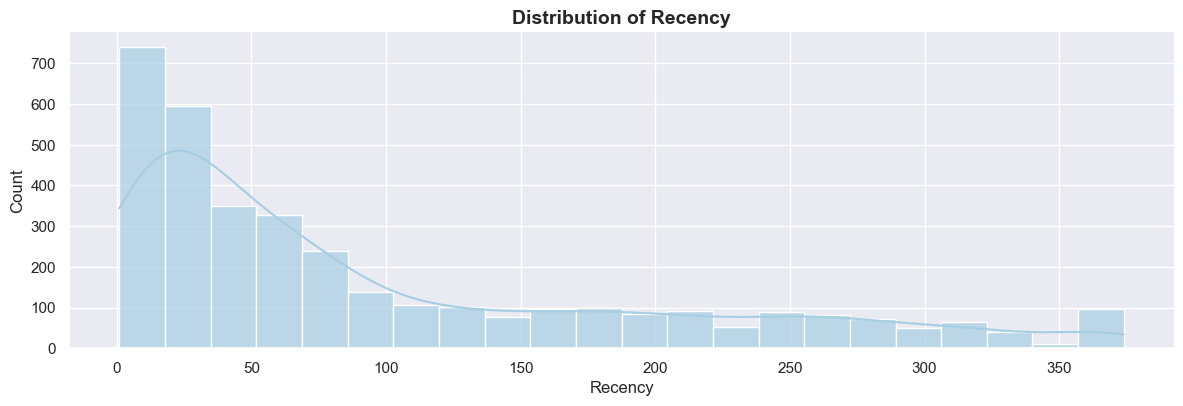

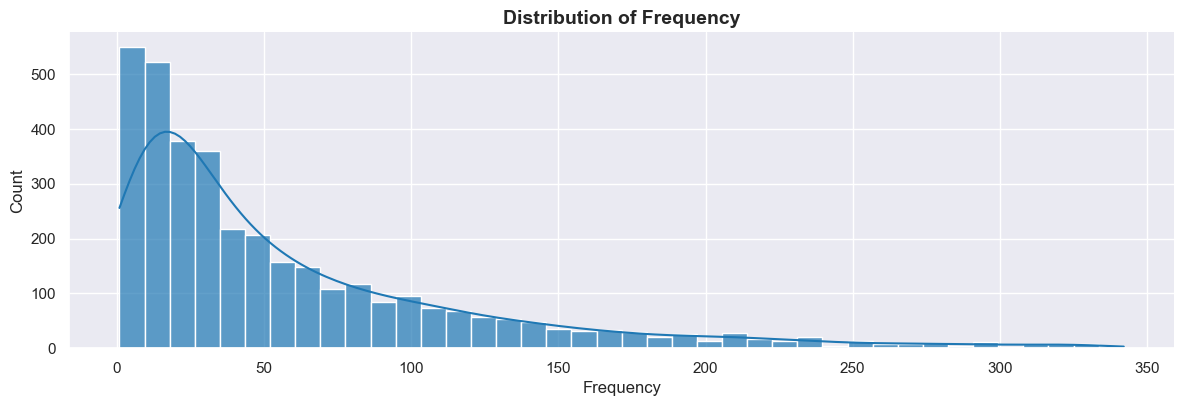

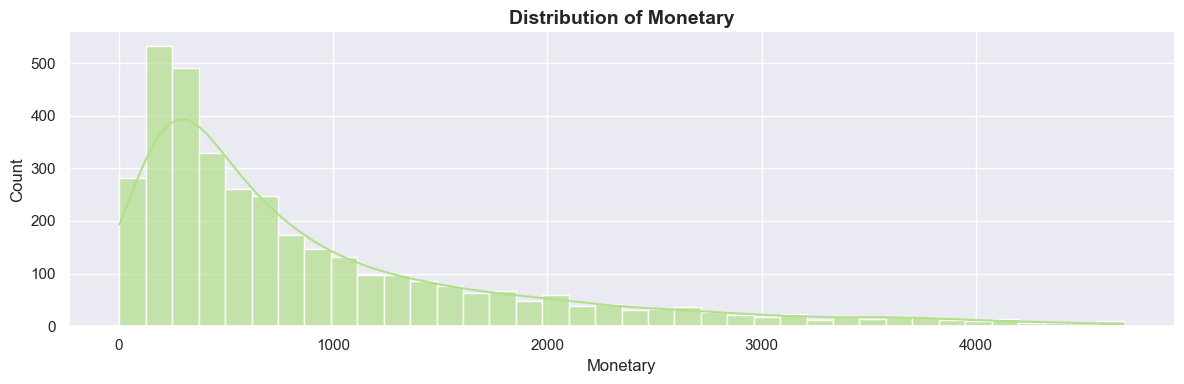

In [31]:
# Distribution of Recency, Frequency and Monetary(原始資料)
check_skew(rfm,'Recency')
check_skew(rfm,'Frequency')
check_skew(rfm,'Monetary')

sns.set()

sns.displot(x = 'Recency', data = rfm, kde = True, color = '#a6cee3', height = 4, aspect = 3, alpha = 0.7)
plt.title('Distribution of Recency', fontsize = 14, fontweight = 'bold')

sns.displot(x = 'Frequency', data = rfm, kde = True, color = '#1f78b4', height = 4, aspect = 3, alpha = 0.7)
plt.title('Distribution of Frequency', fontsize = 14, fontweight = 'bold')

sns.displot(x = 'Monetary', data = rfm, kde = True, color = '#b2df8a', height = 4, aspect = 3, alpha = 0.7)
plt.title('Distribution of Monetary', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

K-means gives the best result under the following conditions:

Data’s distribution is not skewed (i.e. long-tail distribution)
右偏態的資料應以log對數轉換處理偏態

Data is standardised (i.e. mean of 0 and standard deviation of 1).


In [32]:
# 以log對數轉換處理偏態
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
check_skew(rfm_log,'Recency')
check_skew(rfm_log,'Frequency')
check_skew(rfm_log,'Monetary')

Recency's: Skew: -0.6103582550494345
Frequency's: Skew: -0.52735225855163
Monetary's: Skew: -0.25470751056222585


In [33]:
# Standardization
scaler = StandardScaler()
rfm_standard = scaler.fit_transform(rfm_log) #scaler.fit_transform()直接進行標準化的函式
rfm_standard = pd.DataFrame(rfm_standard)
rfm_standard.columns = ['Recency', 'Frequency', 'Monetary']
rfm_standard.head()

,Recency,Frequency,Monetary
0,-2.375133,0.945459,1.919617
1,-1.863182,1.486933,1.895734
2,-2.075202,0.487099,0.492392
3,1.077025,-1.394070,-1.722004
4,0.262189,0.282195,0.499079


Recency's: Skew: -0.6103582550494331
Frequency's: Skew: -0.52735225855163
Monetary's: Skew: -0.2547075105622269


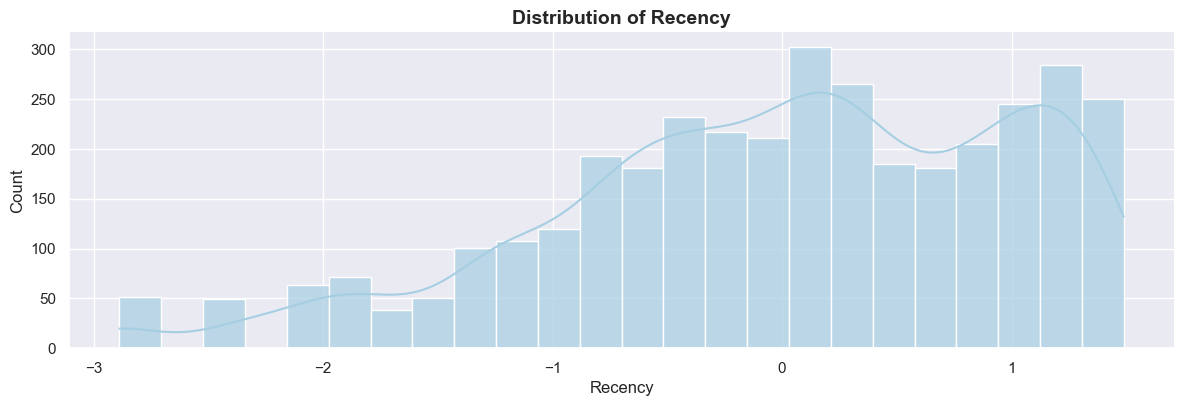

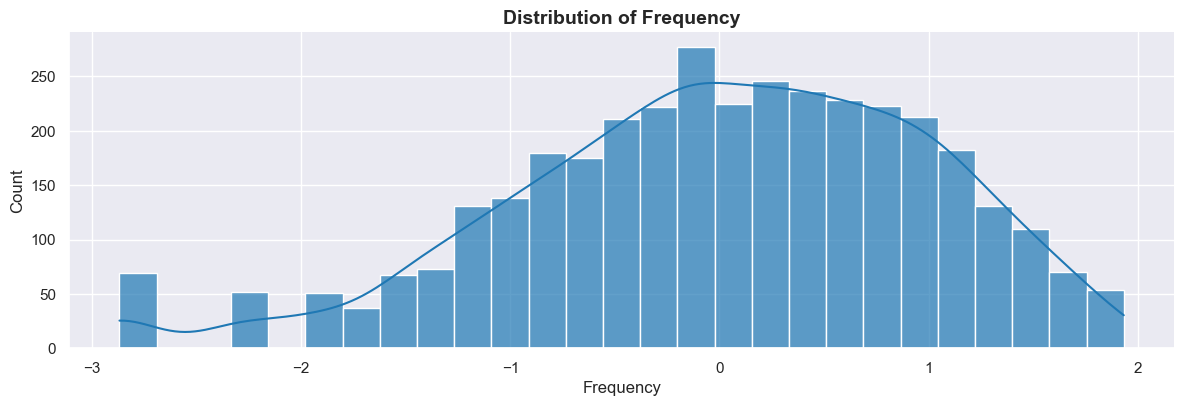

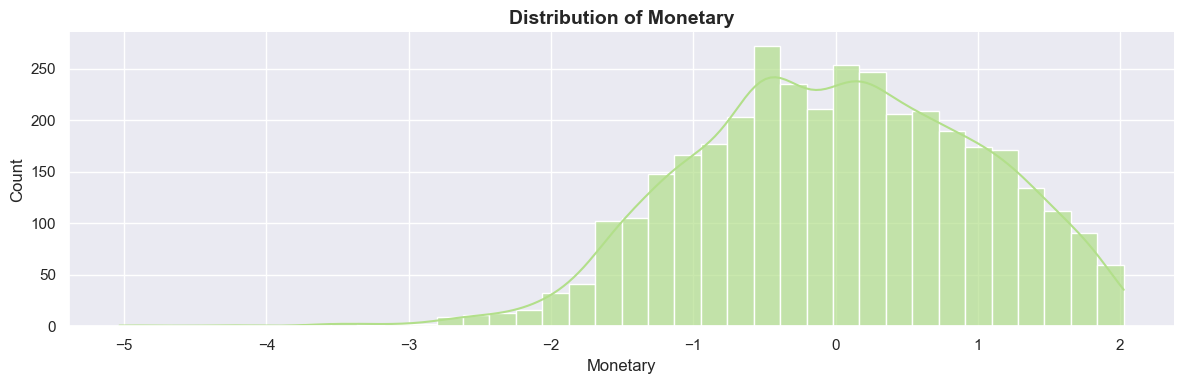

In [34]:
# Distribution of Recency, Frequency and Monetary (經過對數轉換及標準化來降低偏度)
check_skew(rfm_standard,'Recency')
check_skew(rfm_standard,'Frequency')
check_skew(rfm_standard,'Monetary')

sns.set()

sns.displot(x = 'Recency', data = rfm_standard, kde = True, color = '#a6cee3', height = 4, aspect = 3, alpha = 0.7)
plt.title('Distribution of Recency', fontsize = 14, fontweight = 'bold')

sns.displot(x = 'Frequency', data = rfm_standard, kde = True, color = '#1f78b4', height = 4, aspect = 3, alpha = 0.7)
plt.title('Distribution of Frequency', fontsize = 14, fontweight = 'bold')

sns.displot(x = 'Monetary', data = rfm_standard, kde = True, color = '#b2df8a', height = 4, aspect = 3, alpha = 0.7)
plt.title('Distribution of Monetary', fontsize = 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

b. Determine the Optimal Number of Clusters(K) Using Elbow Method and Silhouette Coefficient

Find the Optimal Number of Clusters Using Elbow Method and Silhouette Coefficient.

In [35]:
# Elbow Method
wcss = []

for k in range(1, 9): #測試將資料分為1~8群
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_standard)
    wcss.append(kmeans.inertia_)

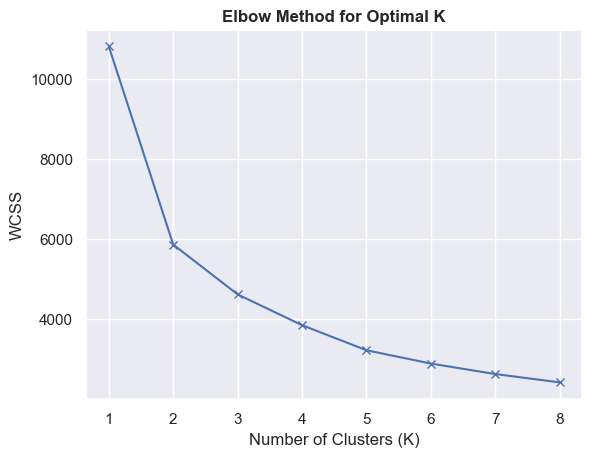

In [36]:
plt.plot(range(1, 9), wcss, marker = 'x')
plt.title('Elbow Method for Optimal K', fontweight = 'bold')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

In [37]:
# Silhouette Coefficient
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_standard)
    silhouette_scores.append(silhouette_score(rfm_standard, kmeans.labels_))

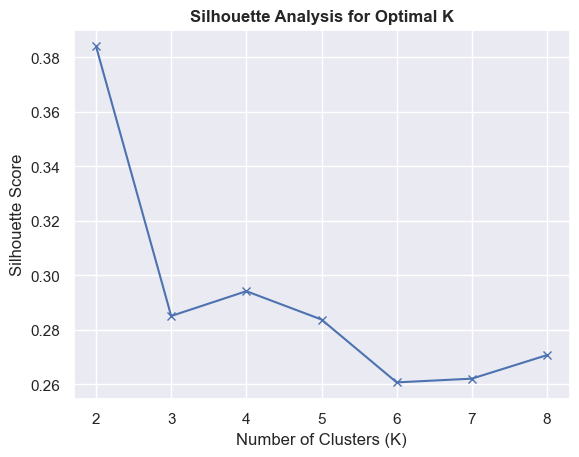

In [38]:
plt.plot(range(2, 9), silhouette_scores, marker = 'x')
plt.title('Silhouette Analysis for Optimal K', fontweight = 'bold')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

c. K-Means Clustering

In [39]:
# Choose K=4
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
kmeans.fit(rfm_standard) #以對數轉換及標準化後的dataframe計算kmeans
cluster_labels = kmeans.labels_
cluster_labels

array([0, 0, 0, ..., 2, 3, 0])

In [40]:
rfm_k4= rfm.assign(K_Cluster = cluster_labels)
rfm_k4.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,K_Cluster
0,12747,2,103,4196.01,4,4,4,12,0
1,12749,4,199,4090.88,4,4,4,12,0
2,12820,3,59,942.34,4,3,3,10,0
3,12821,214,6,92.72,1,1,1,3,2
4,12822,71,46,948.88,2,3,3,8,1


In [41]:
rfm_k4.tail()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,K_Cluster
3597,18278,74,9,173.90,2,1,1,4,2
3598,18280,278,10,180.60,1,1,1,3,2
3599,18281,181,7,80.82,1,1,1,3,2
3600,18282,8,12,178.05,4,1,1,6,3
3601,18287,43,70,1837.28,3,3,4,10,0


In [43]:
rfm_k4.groupby('K_Cluster').mean().round(1)

,Recency,Frequency,Monetary,RFM_Score
K_Cluster,,,,
0,24.0,131.2,1969.2,10.9
1,139.0,49.1,802.5,7.1
2,187.0,10.2,217.7,4.1
3,22.3,31.6,437.0,7.6


In [44]:
rfm_k4['K_Cluster'].value_counts(normalize=True) #四個類群各占總客戶比重

1    0.306774
0    0.275958
2    0.242643
3    0.174625
Name: K_Cluster, dtype: float64

In [45]:
rfm_k4.describe() #不需要對K_Cluster計算，重新整理如下

,Recency,Frequency,Monetary,RFM_Score,K_Cluster
count,3602.000000,3602.000000,3602.000000,3602.000000,3602.000000
mean,98.553026,59.264020,918.716070,7.501388,1.315936
std,100.676700,63.263276,926.513658,2.739069,1.057164
min,1.000000,1.000000,2.900000,3.000000,0.000000
25%,22.000000,15.000000,277.055000,5.000000,0.000000
50%,57.000000,35.000000,576.580000,8.000000,1.000000
75%,157.000000,82.000000,1245.632500,10.000000,2.000000
max,374.000000,342.000000,4690.310000,12.000000,3.000000


In [46]:
rfm_k4.describe().loc[['count', 'mean'],'Recency':'RFM_Score'] #final資料表，rfm_k4就是加上K_Cluster分群號碼的rfm而已，其他資料欄相同

,Recency,Frequency,Monetary,RFM_Score
count,3602.000000,3602.00000,3602.00000,3602.000000
mean,98.553026,59.26402,918.71607,7.501388


In [47]:
rfm_standard.head()

,Recency,Frequency,Monetary
0,-2.375133,0.945459,1.919617
1,-1.863182,1.486933,1.895734
2,-2.075202,0.487099,0.492392
3,1.077025,-1.394070,-1.722004
4,0.262189,0.282195,0.499079


In [48]:
rfm_standard['CustomerID'] = rfm['CustomerID']
rfm_standard['K_Cluster'] = rfm_k4['K_Cluster']
rfm_standard.head()

,Recency,Frequency,Monetary,CustomerID,K_Cluster
0,-2.375133,0.945459,1.919617,12747,0
1,-1.863182,1.486933,1.895734,12749,0
2,-2.075202,0.487099,0.492392,12820,0
3,1.077025,-1.394070,-1.722004,12821,2
4,0.262189,0.282195,0.499079,12822,1


In [49]:
rfm_melt = pd.melt(rfm_standard,
                   id_vars = ['CustomerID', 'K_Cluster'],
                   value_vars = ['Recency', 'Frequency', 'Monetary'],
                   var_name = 'Metric',
                   value_name = 'Value')
rfm_melt.head()

,CustomerID,K_Cluster,Metric,Value
0,12747,0,Recency,-2.375133
1,12749,0,Recency,-1.863182
2,12820,0,Recency,-2.075202
3,12821,2,Recency,1.077025
4,12822,1,Recency,0.262189


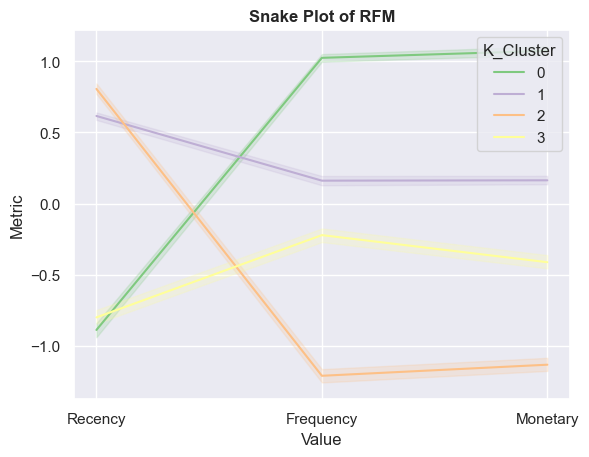

In [66]:
sns.lineplot(x='Metric', y='Value', hue='K_Cluster', data=rfm_melt, palette='Accent')
plt.title('Snake Plot of RFM', fontweight = 'bold')
plt.xlabel('Value')
plt.ylabel('Metric')
plt.show()

In [71]:
rfm_standard.groupby('K_Cluster').mean().round(1)

,Recency,Frequency,Monetary
K_Cluster,,,
0,-0.9,1.0,1.1
1,0.6,0.2,0.2
2,0.8,-1.2,-1.1
3,-0.8,-0.2,-0.4


In [54]:
rfm_k4.to_excel("RFM_K4.xlsx", sheet_name='rfm_k4')

In [55]:
df.to_excel('df_cleaned.xlsx', sheet_name='df')